In [2]:
#!/usr/bin/env python
from umi_tools import network
%matplotlib inline
import matplotlib.pyplot as plt
import pysam
import sys
import json
import pandas as pd
import os
import numpy as np
import networkx as nx
from collections import defaultdict

In [3]:
#helper hamming distance
def hamming_distance(a, b):
    if len(a) != len(b):
        return None  # Returning None to indicate undefined Hamming distance for different lengths

    # Count the number of differences
    count_differences = 0
    for char_a, char_b in zip(a, b):
        if char_a != char_b:
            count_differences += 1

    return count_differences


In [4]:
### Extract 30-mer, CB and UMI from bam file and append to DataFrame
def bam2df (fin):
    samfile = pysam.AlignmentFile(fin, "rb", check_sq=False)
    Mer = []
    CB = []
    UMI = []
    for line in samfile:
        line=line.to_string()
        if line.strip():
            if len(line.split("\t"))==23:
                mer = line.split("\t")[9]
                cb = line.split("\t")[19]
                umi = line.split("\t")[22]
                #test = [line.split("\t")[9], line.split("\t")[19], line.split("\t")[22]]
                #read = "\t".join([line.split("\t")[i] for i in [9,19,22]])
                Mer.append(mer)
                CB.append(cb)
                UMI.append(umi)
    #print('CB type=', type(CB))
    df = pd.DataFrame({'Mer':Mer, 'CB':CB, 'UMI':UMI})
    samfile.close()
    #print(df.head())
    df['Mer']=df.Mer.str[20:50]
    #print(df.head())
    df=df.groupby(['Mer','CB','UMI']).size().reset_index(name='count').sort_values(by='count', ascending=False)
    return df

In [286]:
df = bam2df('./post.S1.barcodes.bam')

In [11]:
df.to_csv('./post.S1.barcodes.csv', sep='\t')

In [264]:
df_test = pd.read_csv('./post.S1.barcodes_50.csv', delimiter='\t')

# Check the DataFrame structure
print(df_test.head())


   Unnamed: 0   Mer                       CB                UMI    count
0       10577  CCCC  CB:Z:TTACTGTAGCGTGCCT-1  UB:Z:CACACGCGCAGG  7968774
1       27943  CCCC  CB:Z:ATTATCCGTAGTGGCA-1  UB:Z:TCCACTAACGGC  6622221
2       39635  CCCA  CB:Z:TGCATCCTCACATCAG-1  UB:Z:CTTTGCACTAGC  2801234
3       39635  ACAT  CB:Z:TGCATCCTCACATCAG-1  UB:Z:CTTTGCACTAGC  2801234
4       15852  CCAT  CB:Z:TGCATCCGTAGGCTGA-1  UB:Z:TCACCAAGTTGT  2088295


In [47]:
## First collapse of the extracted 30mer-CB-UMI to identical lines + trim to 30-mer
### Cut synbar to 30-mer and collapse tables to one occurence of "30mer-CB-UMI"
#def first_collapse (df):
#	df['Mer']=df.Mer.str[20:50]
#    df=df.groupby(['Mer','CB','UMI']).size().reset_index(name='count').sort_values(by='count', ascending=False)
#    return df

### Demuxing extracted 30-mers on a 'per cell barcode' basis  
def demux_nmer(df,fileout, hamming):
	grouped = df.groupby("CB")
	for name, group in grouped:
		cb = []
		cbc = dict()
		for row_index, row in group.iterrows():
			cols=row['Mer']+'|'+row['CB']+'|'+row['UMI']
			cols = bytes(cols, "ascii")
			cb.append(cols)
			cbc[cols]=int(row['count'])
		uc = network.UMIClusterer()
		CBclusters = uc(cbc, int(hamming))
		cbFinal = dict()
		for l in CBclusters:  # This is a list with the first element the dominant barcode
			cbFinal[l[0]] = 0
			for x in l:  # Iterate over all barcodes in a cluster
				cbFinal[l[0]] += cbc[x]
		
        ## write to a final barcode table file
		with open(fileout, 'a') as f:
			for k, v in cbFinal.items():
				k=str(k)
				k = k.replace("b", "").replace("'", "")
				k="\t".join(k.split("|"))
				f.write(k+'\t'+str(v) + '\n')
### Cut synbar to 30-mer and collapse tables to one occurence of "30mer-CB-UMI"

In [202]:
def compute_hamming_threshold(df, output_file):
    
    
    
    mers = df['Mer'].unique()  # Extract unique Mers
    details = df.drop_duplicates(subset=['Mer']).set_index('Mer')  # Get details for each Mer
    
    # Join the total counts for each 'Mer'
    mer_counts = df.groupby('Mer')['count'].sum()
    details = details.join(mer_counts.rename('Total_Count'))

    with open(output_file, 'w') as f:
        # Write the header for the CSV file
        f.write("Mer,Compared_Mer,Mer_Count,CB,UMI,Distance\n")

        # Compute pairwise Hamming distances
        for i in range(len(mers)):
            for j in range(i + 1, len(mers)):
                distance = hamming_distance(mers[i], mers[j])
                if distance is not None:
                    # Retrieve CB, UMI, and count for each Mer
                    mer_details = details.loc[mers[i]]
                    # Write each comparison detail to the file
                    f.write(f"{mers[i]},{mers[j]},{mer_details['Total_Count']},"
                            f"{mer_details['CB']},{mer_details['UMI']},{distance}\n")


In [277]:
def deduplicate_on_mer(df, fout, hamming):
    # Ensure df is sorted by count in descending order for each Mer
    df.sort_values(by=['count'], ascending=[False], inplace=True)

    # Group by 'Mer' and sum up counts, pick the dominant Mer based on the highest count
    grouped = df.groupby('Mer')
    final_counts = {}
    mer_dominant_details = {}

    for mer, group in grouped:
        final_counts[mer] = group['count'].sum()
        dominant_row = group.iloc[0]
        mer_dominant_details[mer] = {'CB': dominant_row['CB'], 'UMI': dominant_row['UMI']}

    # List of all unique Mer sequences for pairwise comparison
    mers = list(final_counts.keys())

    # Map to keep track of which Mer each Mer should collapse into
    mer_collapse_map = {mer: mer for mer in mers}

    # Compare each Mer with every other Mer and collapse based on Hamming distance and counts
    for i in range(len(mers)):
        for j in range(i + 1, len(mers)):
            distance = hamming_distance(mers[i], mers[j])
            if distance is not None and distance <= hamming:
                # Determine which Mer has a higher count and collapse accordingly
                if final_counts[mers[i]] >= final_counts[mers[j]]:
                    mer_collapse_map[mers[j]] = mers[i]
                else:
                    mer_collapse_map[mers[i]] = mers[j]

    # Aggregate counts for each final Mer
    collapsed_counts = defaultdict(int)
    for mer, collapse_to in mer_collapse_map.items():
        final_mer = mer_collapse_map[collapse_to]  # Follow through to find the ultimate Mer to collapse into
        collapsed_counts[final_mer] += final_counts[mer]

    # Write the results to a file
    with open(fout, 'w') as f:
        f.write("Mer\tTotal_Count\tCB\tUMI\n")
        for mer in collapsed_counts:
            cb = mer_dominant_details[mer]['CB']
            umi = mer_dominant_details[mer]['UMI']
            count = collapsed_counts[mer]
            f.write(f"{mer}\t{count}\t{cb}\t{umi}\n")


In [7]:
def main (fin, fout1, fout2, hamming):
    if os.path.isfile(sys.argv[2]):
        os.remove(sys.argv[2])
    if os.path.isfile(sys.argv[3]):
        os.remove(sys.argv[3])
    fin = sys.argv[1]
    fout1 = sys.argv[2]
    fout2 = sys.argv[3]
    hamming = sys.argv[4]
    print('Extracting barcodes from BAM')
    df = bam2df(fin)
    print('Demuxing 30-mers')
    demux_nmer(df,fout1, hamming)
    print('Demuxing 30-mers based on Mer')
    deduplicate_on_mer(df,fout2, hamming)

def usage():
    print("Usage:   python ", sys.argv[0]," file_in file_out hamming_distance")
    print("'file_in' is a bam file")
    print("'file_out' is final table of collapsed barcodes") 
    print("'hamming_distance' for 30-mer dedup, usually 1")
    print('collapses identical 30mer-CB-UMI, using user-defined hamming distance')



if __name__=='__main__':
    if len(sys.argv) == 5:
        main(sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4])
    else:
        usage()

Usage:   python  /opt/anaconda3/envs/umi/lib/python3.10/site-packages/ipykernel_launcher.py  file_in file_out hamming_distance
'file_in' is a bam file
'file_out' is final table of collapsed barcodes
'hamming_distance' for 30-mer dedup, usually 1
collapses identical 30mer-CB-UMI, using user-defined hamming distance


In [278]:
hamming = 1
compute_hamming_threshold(df, './ham.csv')
deduplicate_on_mer(df, './output_mer.csv', hamming)
demux_nmer(df, './output_umi.csv', hamming)

In [399]:
def plot_count_distribution(pre_collapse_df, post_collapse_df, post_collapse_umi):
    # Determine the maximum count to set y-axis limits consistently across all plots
    plt.figure(figsize=(18, 9))
    
    # Plotting pre-collapse data using the DataFrame index as the x-axis
    plt.subplot(1, 3, 1)
    pre_collapse_df['count'][:20].plot(kind='bar', color='blue', alpha=0.7)
    plt.ylim(0, post_collapse_df['Total_Count'].max())
    plt.title('Pre-collapse Count Distribution')
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    

    # Plotting post-collapse data using the DataFrame index as the x-axis
    post_collapse_df.sort_values(by=['Total_Count'], ascending=[False], inplace=True)
    plt.subplot(1, 3, 2)
    post_collapse_df['Total_Count'][:20].plot(kind='bar', color='green', alpha=0.7)
    plt.ylim(0, post_collapse_df['Total_Count'].max())
    plt.title('Mer Post-collapse Distribution')
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    
    # Plotting post-collapse UMI data using the DataFrame index as the x-axis
    post_collapse_umi.sort_values(by=['Total_Count'], ascending=[False], inplace=True)
    plt.subplot(1, 3, 3)
    post_collapse_umi['Total_Count'][:20].plot(kind='bar', color='red', alpha=0.7)
    plt.ylim(0, post_collapse_df['Total_Count'].max())
    plt.title('UMI Post-collapse Distribution')
    plt.xlabel('Index')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


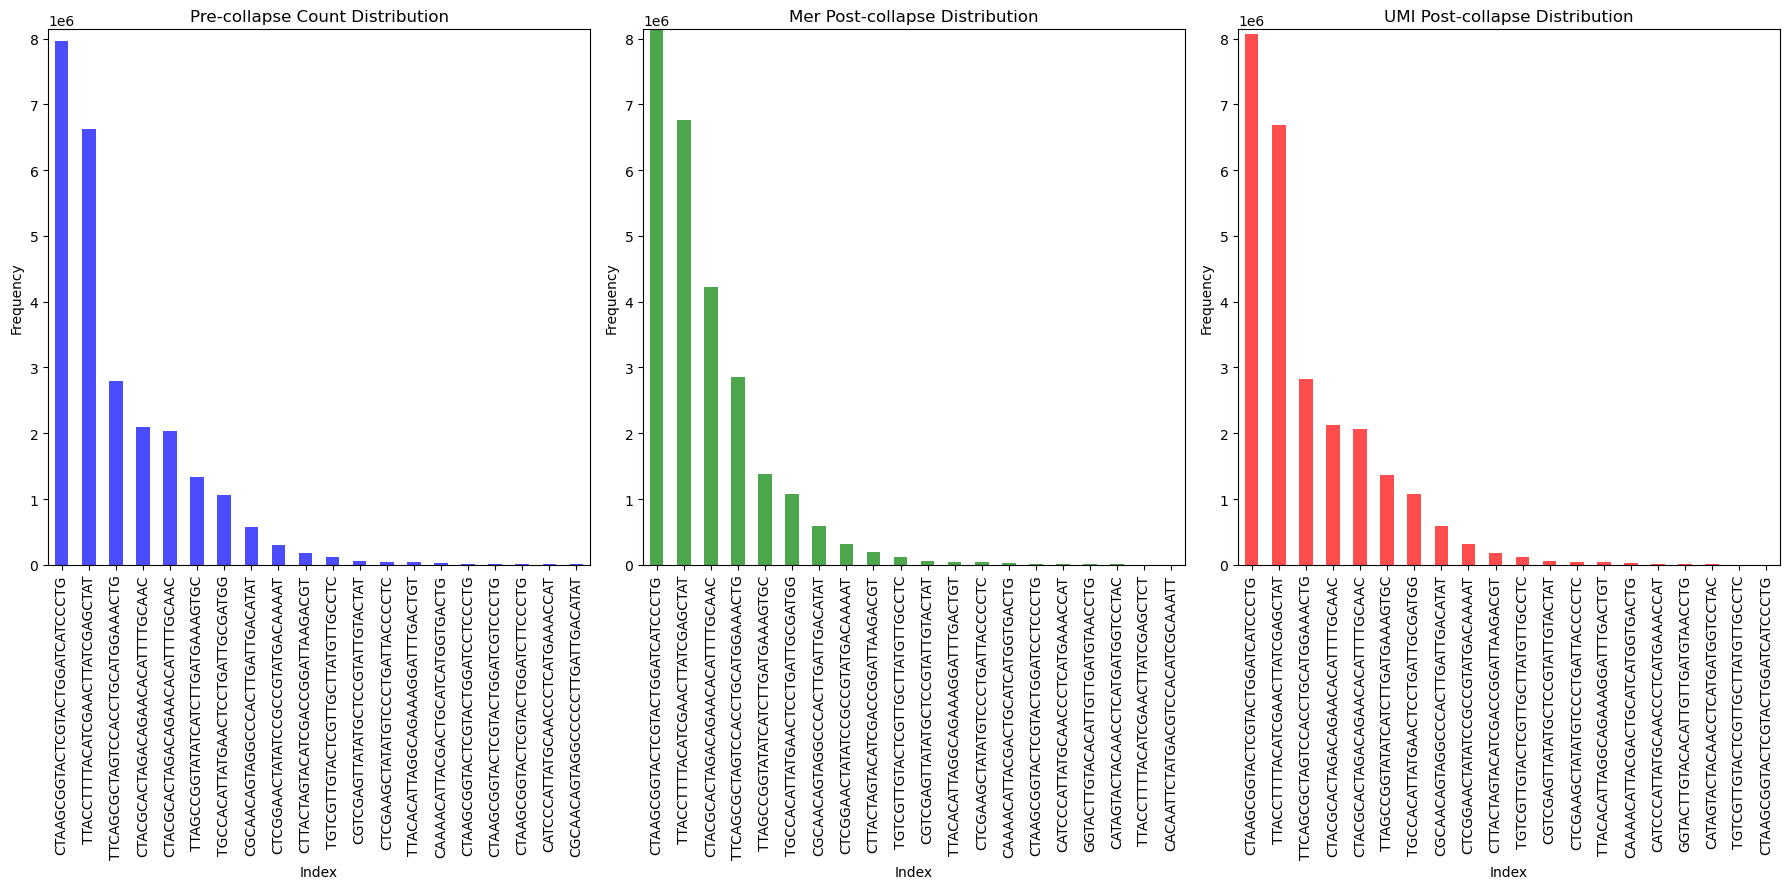

In [400]:
plot_count_distribution(df, df_mer, df_umi)

In [318]:
total_count_before = df_test['count'].max()
print("Max before collapsing:", total_count_before)
total_count_after = df_50['Total_Count'].max()  # Ensure 'Total_Count' is the column with aggregated counts
print("Max count after collapsing:", total_count_after)
total_count_after = df_50_umi['Total_Count'].max()  # Ensure 'Total_Count' is the column with aggregated counts
print("Max count after collapsing:", total_count_after)



Max before collapsing: 7968774
Max count after collapsing: 8023157
Max count after collapsing: 8028990


In [ ]:
def plot_histogram(pre_collapse_df, post_collapse_df, post_collapse_umi):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    _, bins = np.histogram(np.log10(pre_collapse_df['count'] + 1), bins='auto')
    plt.hist(pre_collapse_df['count'], bins=10**bins)
    plt.ylim(0, post_collapse_df['Total_Count'].max())
    plt.title('Pre-collapse Count Distribution')
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    

    # Plotting post-collapse data using the DataFrame index as the x-axis
    post_collapse_df.sort_values(by=['Total_Count'], ascending=[False], inplace=True)
    plt.subplot(1, 3, 2)
    _, bins = np.histogram(np.log10(post_collapse_df['Total_Count'] + 1), bins='auto')
    plt.hist(post_collapse_df['Total_Count'], bins=10**bins)
    plt.title('Mer Post-collapse Distribution')
    plt.xlabel('Index')
    plt.ylabel('Frequency')
    
    # Plotting post-collapse UMI data using the DataFrame index as the x-axis
    post_collapse_umi.sort_values(by=['Total_Count'], ascending=[False], inplace=True)
    plt.subplot(1, 3, 3)
    _, bins = np.histogram(np.log10(post_collapse_umi['Total_Count'] + 1), bins='auto')
    plt.hist(post_collapse_umi['Total_Count'], bins=10**bins)
    plt.ylim(0, post_collapse_df['Total_Count'].max())
    plt.title('UMI Post-collapse Distribution')
    plt.xlabel('Index')
    plt.ylabel('Frequency')


    #plt.gca().set_xscale("log")
    
    plt.tight_layout()
    plt.show()